# Heart Disease Risk Prediction

> Cardiovascular disease or heart disease describes a range of conditions that affect your heart. Diseases under the heart disease umbrella include blood vessel diseases, such as coronary artery disease. From WHO statistics every year 17.9 million dying from heart disease. The medical study says that human life style is the main reason behind this heart problem. Apart from this there are many key factors which warns that the person may/maynot getting chance of heart disease.

> <img style="float: centre;" src="https://www.canwelivebetter.bayer.com/sites/default/files/2018-05/NEW_Heartbeat_looping_GIF_NORMAL_0.gif" width="600px"/>

> From the dataset if we create suitable machine learning technique which can predict the risk of getting a heart disease than it might really help patients and Doctors in many ways. 



First download some uncommon packages used in this notebook:

- `shap` is a library that explains predictions made by machine learning models.
- `lifelines` is a library consisting various tools for medical survival analysis

In [ ]:
!pip install shap
!pip install lifelines

In [7]:
import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from util_riskmodel import load_data, cindex

<a name='2'></a>
## 2. Load the Dataset

Run the next cell to load in the NHANES I epidemiology dataset. This dataset contains various features of hospital patients as well as their outcomes, i.e. whether or not they died within 10 years.

In [ ]:
X_dev, X_test, y_dev, y_test = load_data(10)

The dataset has been split into a development set (or dev set), which we will use to develop our risk models, and a test set, which we will use to test our models.

We further split the dev set into a training and validation set, respectively to train and tune our models, using a 75/25 split.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=31)

In [11]:
print("X_train shape: {}".format(X_train.shape))
X_train.head()

X_train shape: (5147, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
1058,49.0,110.0,248.0,1.0,52.7,13.0,4.5,197.0,103.0,1.40,7.2,1.0,NaN,377.0,27.3,8.9,26.134699,60.0
4671,52.0,78.0,146.0,1.0,44.7,12.0,4.1,218.0,124.0,1.44,6.7,2.0,NaN,357.0,34.7,5.1,28.383913,52.0
2349,66.0,90.0,122.0,1.0,46.9,15.0,4.3,183.0,40.0,1.56,6.6,1.0,NaN,290.0,13.8,6.5,34.518571,50.0
9483,25.0,70.0,326.0,1.0,55.8,3.0,4.4,223.0,68.0,1.78,7.2,1.0,NaN,335.0,20.3,6.7,31.651140,69.0
8335,57.0,88.0,774.0,1.0,46.9,30.0,4.2,265.0,81.0,1.69,6.4,2.0,130.0,287.0,28.2,7.7,35.363583,42.0


Our targets `y` will be whether or not the target died within 10 years. Run the next cell to see the target data series.

In [12]:
y_train.head()

1058    False
4671    False
2349    False
9483    False
8335    False
Name: time, dtype: bool

Use the next cell to examine individual cases and familiarize yourself with the features.

In [14]:
i = 1
print(X_train.iloc[i,:])
print("\nDied within 10 years? {}".format(y_train.loc[y_train.index[i]]))

Age                    52.000000
Diastolic BP           78.000000
Poverty index         146.000000
Race                    1.000000
Red blood cells        44.700000
Sedimentation rate     12.000000
Serum Albumin           4.100000
Serum Cholesterol     218.000000
Serum Iron            124.000000
Serum Magnesium         1.440000
Serum Protein           6.700000
Sex                     2.000000
Systolic BP                  NaN
TIBC                  357.000000
TS                     34.700000
White blood cells       5.100000
BMI                    28.383913
Pulse pressure         52.000000
Name: 4671, dtype: float64

Died within 10 years? False


Plotting the missing data: 

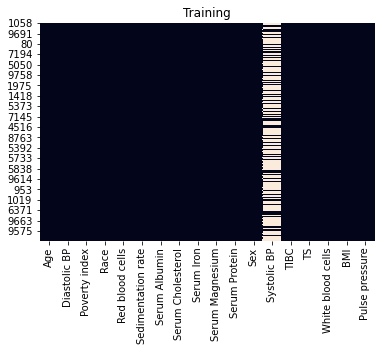

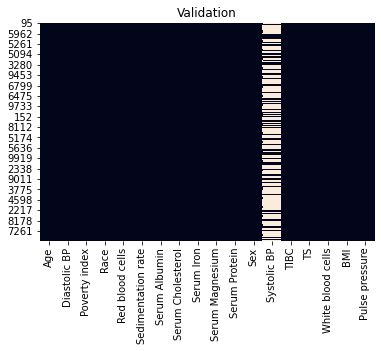

In [15]:
sns.heatmap(X_train.isnull(), cbar=False)
plt.title("Training")
plt.show()

sns.heatmap(X_val.isnull(), cbar=False)
plt.title("Validation")
plt.show()

For each feature, represented as a column, values that are present are shown in black, and missing values are set in a light color.

From this plot, we can see that many values are missing for systolic blood pressure (`Systolic BP`).


Training a random forest with the default hyperparameters results in a model that has better predictive performance than individual decision trees as in the previous section, but this model is overfitting.

We therefore need to tune (or optimize) the hyperparameters, to find a model that both has good predictive performance and minimizes overfitting.

The hyperparameters we choose to adjust will be:

- `n_estimators`: the number of trees used in the forest.
- `max_depth`: the maximum depth of each tree.
- `min_samples_leaf`: the minimum number (if `int`) or proportion (if `float`) of samples in a leaf.

The approach we implement to tune the hyperparameters is known as a grid search:

- We define a set of possible values for each of the target hyperparameters.

- A model is trained and evaluated for every possible combination of hyperparameters.

- The best performing set of hyperparameters is returned.

The cell below implements a hyperparameter grid search, using the C-Index to evaluate each tested model.

In [19]:
# Define ranges for the random forest hyperparameter search 
hyperparams = {
    'n_estimators': [10],
    'max_depth': [4],
    'min_samples_leaf': [1],
}

In [16]:
def grid_search(clf, X_train_hp, y_train_hp, X_val_hp, y_val_hp, hyperparams, fixed_hyperparams={}):
    
    best_estimator = None
    best_hyperparams = {}
    best_score = 0.0

    lists = hyperparams.values()
  
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)

    for i, params in enumerate(param_combinations, 1):
        
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]
            
        estimator = clf(**param_dict, **fixed_hyperparams)

        estimator.fit(X_train_hp, y_train_hp)
      
        preds = estimator.predict_proba(X_val_hp)
        
        estimator_score = cindex(y_val_hp, preds[:,1])

        print(f'[{i}/{total_param_combinations}] {param_dict}')
        print(f'Val C-Index: {estimator_score}\n')

        if estimator_score >= best_score:
                best_score = estimator_score
                best_estimator = estimator
                best_hyperparams = param_dict

    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_estimator, best_hyperparams

In [18]:
# Impute values using the mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)
X_train_mean_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_mean_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

Next we will evaluate our model. We'll use C-Index for evaluation.

>When considering all pairs of patients (A, B), the model says that patient A has a higher risk score than patient B when, in the observed data, patient A actually died and patient B actually lived. In our case, our model is a binary classifier, where each risk score is either 1 (the model predicts that the patient will die) or 0 (the patient will live).
>
> More formally, defining _permissible pairs_ of patients as pairs where the outcomes are different, _concordant pairs_ as permissible pairs where the patient that died had a higher risk score (i.e. our model predicted 1 for the patient that died and 0 for the one that lived), and _ties_ as permissible pairs where the risk scores were equal (i.e. our model predicted 1 for both patients or 0 for both patients), the C-Index is equal to:
>
> $$\text{C-Index} = \frac{\#\text{concordant pairs} + 0.5\times \#\text{ties}}{\#\text{permissible pairs}}$$


In [20]:
rf = RandomForestClassifier

rf_mean_imputed, best_hyperparams_mean_imputed = grid_search(rf, X_train_mean_imputed, y_train,
                                                                     X_val_mean_imputed, y_val,
                                                                     hyperparams, {'random_state': 10})

print("Performance for best hyperparameters:")

y_train_best = rf_mean_imputed.predict_proba(X_train_mean_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")

y_val_best = rf_mean_imputed.predict_proba(X_val_mean_imputed)[:, 1]
print(f"- Val C-Index: {cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_mean_imputed.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_imp):.4f}")

[1/1] {'n_estimators': 10, 'max_depth': 4, 'min_samples_leaf': 1}
Val C-Index: 0.7773681689856826

Performance for best hyperparameters:
- Train C-Index: 0.7635
- Val C-Index: 0.7774
- Test C-Index: 0.7613






You choose to apply **SHAP (SHapley Additive exPlanations) **, a cutting edge method that explains predictions made by black-box machine learning models (i.e. models which are too complex to be understandable by humans as is).

> Given a prediction made by a machine learning model, SHAP values explain the prediction by quantifying the additive importance of each feature to the prediction. SHAP values have their roots in cooperative game theory, where Shapley values are used to quantify the contribution of each player to the game.
> 
> Although it is computationally expensive to compute SHAP values for general black-box models, in the case of trees and forests there exists a fast polynomial-time algorithm. For more details, see the [TreeShap paper](https://arxiv.org/pdf/1802.03888.pdf).

We'll use the [shap library](https://github.com/slundberg/shap) to do this for our random forest model.

In [22]:
X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'risk'] = rf_mean_imputed.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='risk', ascending=False)
X_test_risk.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,risk
2044,74.0,80.0,83.0,1.0,47.6,19.0,4.2,205.0,72.0,1.71,6.9,1.0,180.0,310.0,23.2,10.8,20.900101,100.0,0.625306
8265,67.0,68.0,182.0,1.0,42.7,17.0,3.4,161.0,25.0,1.89,7.4,1.0,110.0,287.0,8.7,10.8,18.547462,42.0,0.580665
6609,72.0,90.0,75.0,1.0,29.3,59.0,3.9,216.0,64.0,1.63,7.4,2.0,182.0,322.0,19.9,9.3,22.281793,92.0,0.578975
5954,67.0,70.0,134.0,1.0,77.7,57.0,3.3,120.0,42.0,1.47,6.4,2.0,120.0,318.0,13.2,8.8,17.612034,50.0,0.566363
7281,70.0,84.0,160.0,2.0,48.9,34.0,4.2,252.0,136.0,1.67,6.9,1.0,180.0,391.0,34.8,8.7,23.405836,96.0,0.563643


We can use SHAP values to try and understand the model output on specific individuals using force plots. Run the cell below to see a force plot on the riskiest individual. 

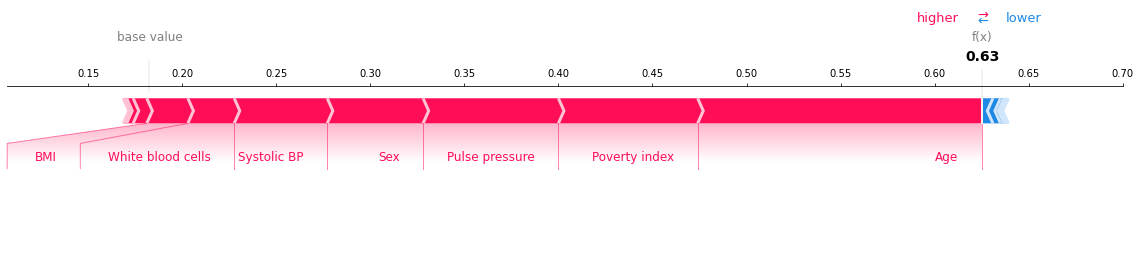

In [23]:
explainer = shap.TreeExplainer(rf_mean_imputed)
i = 0
shap_value = explainer.shap_values(X_test.loc[X_test_risk.index[i], :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

How to read this chart:
- The red sections on the left are features which push the model towards the final prediction in the positive direction (i.e. a higher Age increases the predicted risk).
- The blue sections on the right are features that push the model towards the final prediction in the negative direction (if an increase in a feature leads to a lower risk, it will be shown in blue).

We can see that below 4 features impact the prediction the highest:

- Age
- Poverty index
- Pulse Pressure
- Sex


In [24]:
shap_values = shap.TreeExplainer(rf_mean_imputed).shap_values(X_test)[1]

Run the next cell to see a summary plot of the SHAP values for each feature on each of the test examples. The colors indicate the value of the feature.

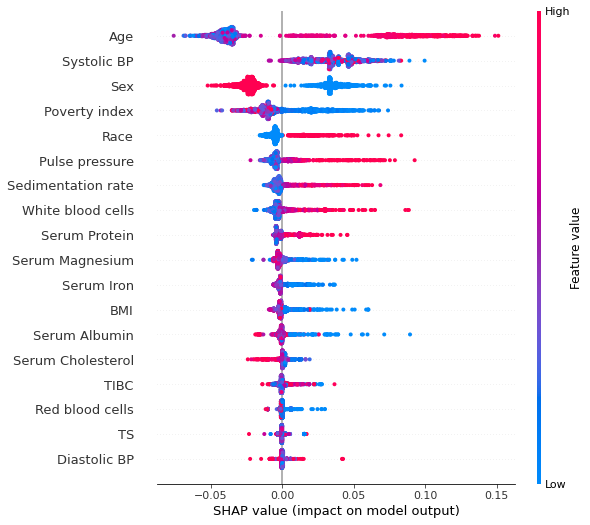

In [25]:
shap.summary_plot(shap_values, X_test)

Clearly we see that being a woman (`sex = 2.0`, as opposed to men for which `sex = 1.0`) has a negative SHAP value, meaning that it reduces the risk of dying within 10 years. High age and high systolic blood pressure have positive SHAP values, and are therefore related to increased mortality. 

You can see how features interact using dependence plots. These plot the SHAP value for a given feature for each data point, and color the points in using the value for another feature. This lets us begin to explain the variation in SHAP value for a single value of the main feature.


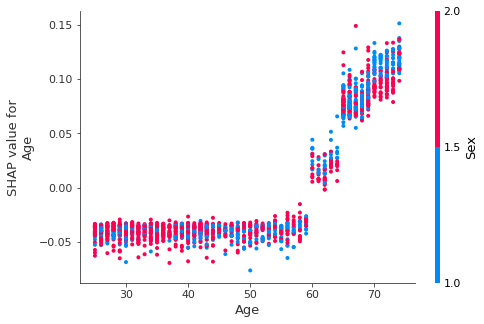

In [26]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index='Sex')

We see that while Age > 50 is generally bad (positive SHAP value), being a woman generally reduces the impact of age. This makes sense since we know that women generally live longer than men.

Let's now look at poverty index and age.

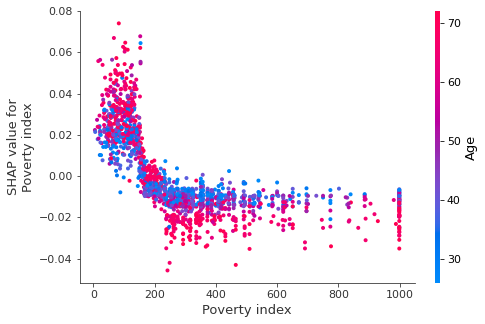

In [27]:
shap.dependence_plot('Poverty index', shap_values, X_test, interaction_index='Age')

We see that the impact of poverty index drops off quickly, and for higher income individuals age begins to explain much of variation in the impact of poverty index.
